# This is the data cleaning Notebok for the project

In [368]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime

In [369]:
df = pd.read_excel("marketing_data.xlsx")

## Data Profiling

In [370]:
df.dtypes

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
Response                 int64
Complain                 int64
dtype: object

## Data Preprocessing

In [371]:
# Converting year of birth into age
current_year = datetime.now().year
df['Age'] = current_year - df['Year_Birth']
print(df[['Age', 'Year_Birth']])
print(df['Age'].unique())

      Age  Year_Birth
0      54        1970
1      63        1961
2      66        1958
3      57        1967
4      35        1989
...   ...         ...
2235   48        1976
2236   47        1977
2237   48        1976
2238   46        1978
2239   55        1969

[2240 rows x 2 columns]
[ 54  63  66  57  35  70  77  45  65  43  55  47  64  58  48  59  68  49
  53  38  52  50  34  37  40  56  69  41  51  46  72  62  60  42  61  67
  44  79  75  76  71  78  39  32  80  73  36  74  30  31  33 131  28  29
 125  81  83  84 124]


In [372]:
from scipy import stats


z_age = np.abs(stats.zscore(df['Age']))
z_income = np.abs(stats.zscore(df['Income']))
# z_buying_power = np.abs(stats.zscore(df['BuyingPower']))
threshold_z = 3


print("Original DataFrame Shape:", df.shape)
age_outlier_indices = np.where(z_age > threshold_z)[0]
income_outlier_indices = np.where(z_income > threshold_z)[0]
# income_buying_power = np.where(z_income > threshold_z)[0]

outlier_indices = np.array(list(set(age_outlier_indices) | set(income_outlier_indices)))

df = df.drop(outlier_indices)
print("DataFrame Shape after Removing Outliers:", df.shape)

Original DataFrame Shape: (2240, 23)
DataFrame Shape after Removing Outliers: (2237, 23)


In [373]:
df['Marital_Status'] = df['Marital_Status'].astype(str)
df.dtypes

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
Response                 int64
Complain                 int64
Age                      int64
dtype: object

In [374]:
# Fixing the format for Dt_customer
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='mixed')
print(df.shape)
df = df[(df['Dt_Customer'].dt.year - df['Year_Birth']) > 18]
print(df.shape)
df['Dt_Customer'] = df['Dt_Customer'].astype(str)
print(df)

(2237, 23)
(2231, 23)
         ID  Year_Birth   Education Marital_Status   Income  Kidhome  \
0      1826        1970  Graduation       Divorced  84835.0        0   
1         1        1961  Graduation         Single  57091.0        0   
2     10476        1958  Graduation        Married  67267.0        0   
3      1386        1967  Graduation       Together  32474.0        1   
4      5371        1989  Graduation         Single  21474.0        1   
...     ...         ...         ...            ...      ...      ...   
2235  10142        1976         PhD       Divorced  66476.0        0   
2236   5263        1977    2n Cycle        Married  31056.0        1   
2237     22        1976  Graduation       Divorced  46310.0        1   
2238    528        1978  Graduation        Married  65819.0        0   
2239   4070        1969         PhD        Married  94871.0        0   

      Teenhome Dt_Customer  Recency  MntWines  ...  MntSweetProducts  \
0            0  2014-06-16        0      

In [375]:
df['Total_Spent'] = (df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds'])
df['BuyingPower'] = df['Total_Spent'] / df['Income'] 

In [376]:
# df.sort_values(by='Income', ascending=True, inplace=True)
# sns.barplot(x='BuyingPower', y='Income', data=df)

In [377]:
df['BuyingPower'].head()

0    0.014027
1    0.010107
2    0.003731
3    0.000339
4    0.004238
Name: BuyingPower, dtype: float64

## Filling all null income values

In [378]:
df['Income'].head()

0    84835.0
1    57091.0
2    67267.0
3    32474.0
4    21474.0
Name: Income, dtype: float64

In [379]:
# Graduation = df[df['Education'] == 'Graduation']
# Graduation.head(50)

unique_values = df['Education'].unique()
print(unique_values)

['Graduation' 'PhD' '2n Cycle' 'Master' 'Basic']


In [380]:
df['Marital_Status'].unique()

array(['Divorced', 'Single', 'Married', 'Together', 'Widow', 'YOLO',
       'Alone', 'Absurd'], dtype=object)

In [381]:
df['Marital_Status'] = df['Marital_Status'].replace(['YOLO', 'Alone', 'Divorced', 'Widow'], 'Single')
df['Marital_Status'] = df['Marital_Status'].replace(['Absurd'], 'Married')

In [382]:
df['Marital_Status'].unique()

array(['Single', 'Married', 'Together'], dtype=object)

In [383]:
def countMembers(row):
    if row['Marital_Status'] == 'Single':
        return row['Kidhome'] + row['Teenhome'] + 1
    else:
        return row['Kidhome'] + row['Teenhome'] + 2

df['HouseHoldMembers'] = df.apply(countMembers, axis=1)

In [384]:
df['Education'] = df['Education'].replace(['2n Cycle'], 'n_cycle')

In [385]:
Graduation_mean = df[df['Education'] == 'Graduation']
Graduation_mean = Graduation_mean['Income'].mean()
print(Graduation_mean)

52656.84290843806


In [386]:
PhD_mean = df[df['Education'] == 'PhD']
PhD_mean = PhD_mean['Income'].mean()
print(PhD_mean)

56088.25833333333


In [387]:
TwoN_Cycle_mean = df[df['Education'] == 'n_Cycle']
TwoN_Cycle_mean = TwoN_Cycle_mean['Income'].mean()
print(TwoN_Cycle_mean)

nan


In [388]:
Master_mean = df[df['Education'] == 'Master']
Master_mean = Master_mean['Income'].mean()
print(Master_mean)

52917.53424657534


In [389]:
Basic_mean = df[df['Education'] == 'Basic']
Basic_mean = Basic_mean['Income'].mean()
print(Basic_mean)

20417.30188679245


In [390]:
df['Total_Children'] = df.loc[:, 'Kidhome'] + df.loc[:, 'Teenhome']
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Age,Total_Spent,BuyingPower,HouseHoldMembers,Total_Children
0,1826,1970,Graduation,Single,84835.0,0,0,2014-06-16,0,189,...,4,6,1,1,0,54,1190,0.014027,1,0
1,1,1961,Graduation,Single,57091.0,0,0,2014-06-15,0,464,...,3,7,5,1,0,63,577,0.010107,1,0
2,10476,1958,Graduation,Married,67267.0,0,1,2014-05-13,0,134,...,2,5,2,0,0,66,251,0.003731,3,1
3,1386,1967,Graduation,Together,32474.0,1,1,2014-11-05,0,10,...,0,2,7,0,0,57,11,0.000339,4,2
4,5371,1989,Graduation,Single,21474.0,1,0,2014-08-04,0,6,...,1,2,7,1,0,35,91,0.004238,2,1


In [391]:
null_income = df[df['Income'].isnull()]
# null_income = null_income.isnull().sum()
null_income['Income'][null_income['Education'] == 'Graduation'] = Graduation_mean
null_income['Income'][null_income['Education'] == 'PhD'] = PhD_mean
null_income['Income'][null_income['Education'] == '2n Cycle'] = TwoN_Cycle_mean
null_income['Income'][null_income['Education'] == 'Master'] = Master_mean
null_income['Income'][null_income['Education'] == 'Basic'] = Basic_mean
print(null_income)

         ID  Year_Birth   Education Marital_Status        Income  Kidhome  \
134    8996        1957         PhD        Married  56088.258333        2   
262    1994        1983  Graduation        Married  52656.842908        1   
394    3769        1972         PhD       Together  56088.258333        1   
449    5255        1986  Graduation         Single  52656.842908        1   
525    8268        1961         PhD        Married  56088.258333        0   
590   10629        1973     n_cycle        Married           NaN        1   
899   10475        1970      Master       Together  52917.534247        0   
997    9235        1957  Graduation         Single  52656.842908        1   
1096   4345        1964     n_cycle         Single           NaN        1   
1185   7187        1969      Master       Together  52917.534247        1   
1213   8720        1978     n_cycle       Together           NaN        0   
1312   8557        1982  Graduation         Single  52656.842908        1   

C:\Users\nigel\AppData\Local\Temp\ipykernel_17240\1739440520.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  null_income['Income'][null_income['Education'] == 'Graduation'] = Graduation_mean
C:\Users\nigel\AppData\Local\Temp\ipykernel_17

In [392]:
df['Income'][df['Income'].isnull()] = null_income['Income']
df.head(50)

C:\Users\nigel\AppData\Local\Temp\ipykernel_17240\140808848.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Income'][df['Income'].isnull()] = null_income['Income']
C:\Users\nigel\AppData\Local\Temp\ipykernel_17240\140808848.py:1: Set

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Age,Total_Spent,BuyingPower,HouseHoldMembers,Total_Children
0,1826,1970,Graduation,Single,84835.0,0,0,2014-06-16,0,189,...,4,6,1,1,0,54,1190,0.014027,1,0
1,1,1961,Graduation,Single,57091.0,0,0,2014-06-15,0,464,...,3,7,5,1,0,63,577,0.010107,1,0
2,10476,1958,Graduation,Married,67267.0,0,1,2014-05-13,0,134,...,2,5,2,0,0,66,251,0.003731,3,1
3,1386,1967,Graduation,Together,32474.0,1,1,2014-11-05,0,10,...,0,2,7,0,0,57,11,0.000339,4,2
4,5371,1989,Graduation,Single,21474.0,1,0,2014-08-04,0,6,...,1,2,7,1,0,35,91,0.004238,2,1
5,7348,1958,PhD,Single,71691.0,0,0,2014-03-17,0,336,...,7,5,2,1,0,66,1192,0.016627,1,0
6,4073,1954,n_cycle,Married,63564.0,0,0,2014-01-29,0,769,...,10,7,6,1,0,70,1215,0.019115,2,0
7,1991,1967,Graduation,Together,44931.0,0,1,2014-01-18,0,78,...,1,3,5,0,0,57,96,0.002137,3,1
8,4047,1954,PhD,Married,65324.0,0,1,2014-11-01,0,384,...,2,9,4,0,0,70,544,0.008328,3,1
9,9477,1954,PhD,Married,65324.0,0,1,2014-11-01,0,384,...,2,9,4,0,0,70,544,0.008328,3,1


In [393]:
df.count()

ID                     2231
Year_Birth             2231
Education              2231
Marital_Status         2231
Income                 2228
Kidhome                2231
Teenhome               2231
Dt_Customer            2231
Recency                2231
MntWines               2231
MntFruits              2231
MntMeatProducts        2231
MntFishProducts        2231
MntSweetProducts       2231
MntGoldProds           2231
NumDealsPurchases      2231
NumWebPurchases        2231
NumCatalogPurchases    2231
NumStorePurchases      2231
NumWebVisitsMonth      2231
Response               2231
Complain               2231
Age                    2231
Total_Spent            2231
BuyingPower            2207
HouseHoldMembers       2231
Total_Children         2231
dtype: int64

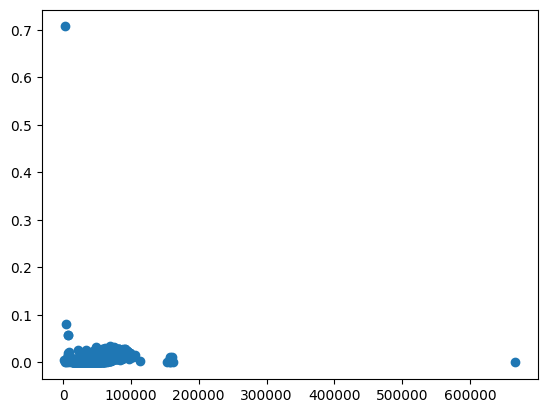

In [394]:
plt.scatter(df['Income'], df['BuyingPower'])

In [395]:
df['TotalPurchases'] = df['NumDealsPurchases'] + df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases']

In [396]:
def calculate_days_diff(row):
  return (today - row['Dt_CustomerConverted']).days

df['Dt_CustomerConverted'] = pd.to_datetime(df['Dt_Customer'])
today = datetime.today()
df['SinceEnrolled'] = df.apply(calculate_days_diff, axis=1)

In [397]:
df = df[df['BuyingPower']< 0.05]

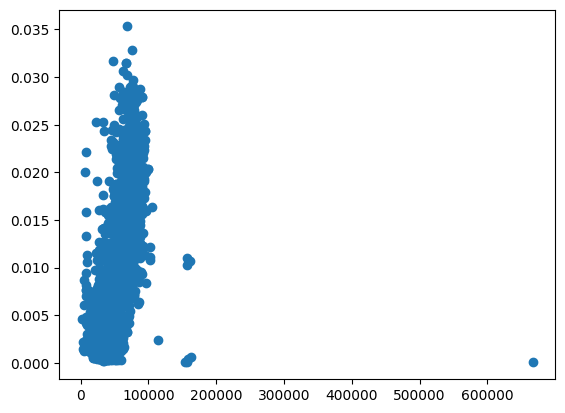

In [398]:
plt.scatter(df['Income'], df['BuyingPower'])    

In [399]:
print(df[df['Marital_Status'] == 'Married'].count())

ID                      855
Year_Birth              855
Education               855
Marital_Status          855
Income                  855
Kidhome                 855
Teenhome                855
Dt_Customer             855
Recency                 855
MntWines                855
MntFruits               855
MntMeatProducts         855
MntFishProducts         855
MntSweetProducts        855
MntGoldProds            855
NumDealsPurchases       855
NumWebPurchases         855
NumCatalogPurchases     855
NumStorePurchases       855
NumWebVisitsMonth       855
Response                855
Complain                855
Age                     855
Total_Spent             855
BuyingPower             855
HouseHoldMembers        855
Total_Children          855
TotalPurchases          855
Dt_CustomerConverted    855
SinceEnrolled           855
dtype: int64


### Customer Lifetime value 

In [400]:
df['CLV'] = (df['Total_Spent'] / 2) * (df['SinceEnrolled'] / 365)

# Average Order Value 

In [401]:
df['AOV'] = df['Total_Spent'] / df['TotalPurchases']

# Saving to Excel 


In [402]:
df.to_excel('Cleaned_Data.xlsx')

In [403]:
df.count()

ID                      2203
Year_Birth              2203
Education               2203
Marital_Status          2203
Income                  2203
Kidhome                 2203
Teenhome                2203
Dt_Customer             2203
Recency                 2203
MntWines                2203
MntFruits               2203
MntMeatProducts         2203
MntFishProducts         2203
MntSweetProducts        2203
MntGoldProds            2203
NumDealsPurchases       2203
NumWebPurchases         2203
NumCatalogPurchases     2203
NumStorePurchases       2203
NumWebVisitsMonth       2203
Response                2203
Complain                2203
Age                     2203
Total_Spent             2203
BuyingPower             2203
HouseHoldMembers        2203
Total_Children          2203
TotalPurchases          2203
Dt_CustomerConverted    2203
SinceEnrolled           2203
CLV                     2203
AOV                     2203
dtype: int64

In [404]:
df = df[df['Income'] < 200000]
df = df[df['AOV'] < 1.7976931348623157e+308]
df.count()


ID                      2199
Year_Birth              2199
Education               2199
Marital_Status          2199
Income                  2199
Kidhome                 2199
Teenhome                2199
Dt_Customer             2199
Recency                 2199
MntWines                2199
MntFruits               2199
MntMeatProducts         2199
MntFishProducts         2199
MntSweetProducts        2199
MntGoldProds            2199
NumDealsPurchases       2199
NumWebPurchases         2199
NumCatalogPurchases     2199
NumStorePurchases       2199
NumWebVisitsMonth       2199
Response                2199
Complain                2199
Age                     2199
Total_Spent             2199
BuyingPower             2199
HouseHoldMembers        2199
Total_Children          2199
TotalPurchases          2199
Dt_CustomerConverted    2199
SinceEnrolled           2199
CLV                     2199
AOV                     2199
dtype: int64

In [405]:
df.to_excel('Threshold_Data.xlsx')